<a href="https://colab.research.google.com/github/sriharikrishna/siamcse23/blob/main/pinn_tapenade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

We will use the PINN approach to solve the PDE

$$\frac{\partial u}{\partial x}=2\cdot\frac{\partial u}{\partial t}+u,$$

with initial condition

$$u(x,0)=6\cdot e^{(-3x)}.$$

The PDE has a known analytical solution, which we note here but will not explicitly use in the code:

$$u(x,t) = 6e^{(-3x-2t)}$$

## Desired Outcome

We want to obtain a neural network that models $u$. In other words, the neural network should take $x$ and $t$ as input, and produce an output $u$ that is close to $u(x,t)$. However, we assume that $u(x,t)$ is not explicitly known. Instead, we define the residual function $f$ as


$$f = \frac{\partial u}{\partial x} - 2\cdot\frac{\partial u}{\partial t} - u,$$

and train our neural network to minimize $f$ at randomly chosen points within a domain that is defined as $x\in [0,2]$ and $t \in [0,1]$ for this exercise.

## Environment Setup

Let us start by importing a few things:

 - PyTorch, to define our neural network.
 - Numpy, which will help us interface PyTorch and Ctypes
 - Ctypes, which we will use to call functions compiled from C

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cpu")
import numpy as np
import ctypes
from numpy.ctypeslib import ndpointer

## Neural Network setup

Now we create a neural net in PyTorch. We (arbitrarily) choose to use a dense neural network with five layers for this tutorial. You could try to use other layer types or sizes, and/or change the number of layers. As always, this is a tradeoff between fidelity, training time, resource usage, etc.

The input of the network is going to consist of two vectors $x$, $t$. These will be interpreted as a vector of pairs $(x_i,t_i)$, and the network will produce an output vector  whose entry $i$ is a prediction for $u(x_i, t_i)$.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5)
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x, t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out) ## For regression, no activation is used in output layer
        return output

## Cost function

We will train the neural net using a cost function that has two parts: Part A forces the function to be correct at $t=0$, and Part B enforces the PDE throughout the domain.

## Part A: Initial condition

Now we create a number of points (here, arbitrarily, 500) randomly spread along the $x$ coordinate, with $t=0$. For each of these points, we evaluate the initial condition
$$u_0 = 6\cdot e^{(-3*x)}.$$

We then define a function that takes a given `net` as an input, evaluates it at our random coordinates, and computes the error between the computed result and the true initial condition using the MSE loss function.

Later, we will train the neural network to satisfy the initial condition.

In [3]:
mse = torch.nn.MSELoss()

# Define the input coordinates and evaluate the function in Numpy
x_bc = np.random.uniform(low=0.0, high=2.0, size=(500,1))
t_bc = np.zeros((500,1))
u_bc = 6*np.exp(-3*x_bc)
# Convert to PyTorch tensors
pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
pt_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)

# Evaluate net at the coordinates and compute MSE loss
def part_A(net):
    net_bc_out = net(pt_x_bc, pt_t_bc)
    return mse(net_bc_out, pt_u_bc)

## Part B: Residual

Now we define the residual function $f$. The function computes predictions for
$$u,$$ $$u_x :=\frac{\partial u}{\partial x},$$
$$u_t :=\frac{\partial u}{\partial t}$$
by evaluating the neural network and its gradients computed with autograd, for a given $x$, $t$. With all these ingredients prepared, we compute the residual using the definition of our PDE:
$$f = u_x - 2\cdot u_t - u$$
If our neural network was a perfect predictor for $u$, we would expect a zero residual for all inputs. Since the neural network is unlikely to be perfect though, we will get some non-zero result. We will train our neural network to minimize the residual throughout the domain.

Note the argument `create_graph=True`, which will allow us to back-propagate through `f` including the calls to `autograd.grad` later, essentially computing second-order derivatives.

In [9]:
def f(x, t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    return u_x - 2*u_t - u

Having defined `f`, we can use it to compute part B of the cost function. To this end, we evaluate `f` at $500$ randomly generated coordinates in our domain, and compute the mismatch between the obtained result and the expected result (which is zero).

Note that we define `part_B` such that the function `f` can be swapped out for something else, because we will later replace it with a function defined in C and differentiated with Tapenade.

In [10]:
def part_B(net, residual=f):
    x_collocation = np.random.uniform(low=0.0, high=2.0, size=(500,1))
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1))
    all_zeros = np.zeros((500,1))
    
    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)
    
    f_out = residual(pt_x_collocation, pt_t_collocation, net) # output of f(x,t)
    return mse(f_out, pt_all_zeros)

## Solving the PDE

Now 

In [12]:
net = Net()
net = net.to(device)
optimizer = torch.optim.Adam(net.parameters())
iterations = 10000
for epoch in range(iterations):
    optimizer.zero_grad() # reset gradients
    mse_u = part_A(net)   # Loss based on initial conditions
    mse_f = part_B(net)   # Loss based on PDE
    loss = mse_u + mse_f  # Combined loss
    
    loss.backward()  # Back-prop
    optimizer.step() # Gradient-based optimization step

    if(epoch%100==0):
        with torch.autograd.no_grad():
    	    print(epoch,"Traning Loss:",loss.data)
    

0 Traning Loss: tensor(3.1544)
100 Traning Loss: tensor(2.9718)
200 Traning Loss: tensor(2.9715)
300 Traning Loss: tensor(2.9705)
400 Traning Loss: tensor(2.9581)
500 Traning Loss: tensor(2.7639)
600 Traning Loss: tensor(2.2393)
700 Traning Loss: tensor(1.7250)
800 Traning Loss: tensor(1.1701)
900 Traning Loss: tensor(0.7846)
1000 Traning Loss: tensor(0.5955)
1100 Traning Loss: tensor(0.5043)
1200 Traning Loss: tensor(0.3350)
1300 Traning Loss: tensor(0.2863)
1400 Traning Loss: tensor(0.2496)
1500 Traning Loss: tensor(0.1844)
1600 Traning Loss: tensor(0.2272)
1700 Traning Loss: tensor(0.1849)
1800 Traning Loss: tensor(0.1124)
1900 Traning Loss: tensor(0.0916)
2000 Traning Loss: tensor(0.0690)
2100 Traning Loss: tensor(0.0808)
2200 Traning Loss: tensor(0.0863)
2300 Traning Loss: tensor(0.0503)
2400 Traning Loss: tensor(0.0787)
2500 Traning Loss: tensor(0.0635)
2600 Traning Loss: tensor(0.0444)
2700 Traning Loss: tensor(0.0423)
2800 Traning Loss: tensor(0.0432)
2900 Traning Loss: tensor(

# Plot the result

Now that the neural net is trained, we can evaluate it at regularly spaced points to create a nice plot.
The gory details of using matplotlib are inside a function, so we can re-use it later after training other neural nets.

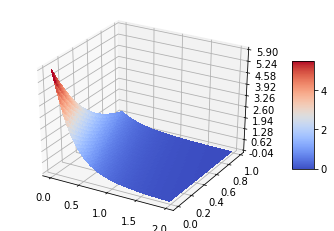

In [16]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def plotnet(net):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    x=np.arange(0,2,0.02)
    t=np.arange(0,1,0.02)
    ms_x, ms_t = np.meshgrid(x, t)
    x = np.ravel(ms_x).reshape(-1,1)
    t = np.ravel(ms_t).reshape(-1,1)
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_u = net(pt_x,pt_t)
    u=pt_u.data.cpu().numpy()
    ms_u = u.reshape(ms_x.shape)
    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plotnet(net)

In [ ]:
class CustomFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, u_x, u_t, u):
        #ctx.save_for_backward(fwdinput)
        #print("custom input ", u_x[0:1], u_t[0:1], u[0:1])
        res = u_x - 2*u_t - u
        #print("custom output ", res[0:1])
        return res

    @staticmethod
    def backward(ctx, grad_output):
        #fwdinput, = ctx.saved_tensors
        grad_u = -grad_output
        grad_u_t = -2*grad_output
        grad_u_x = grad_output
        return grad_u_x, grad_u_t, grad_u

customfunc = CustomFunc.apply

In [ ]:
from torch.autograd import gradcheck
u_x = torch.randn(500,1,dtype=torch.double,requires_grad=True)
u_t = torch.randn(500,1,dtype=torch.double,requires_grad=True)
u = torch.randn(500,1,dtype=torch.double,requires_grad=True)
test = gradcheck(customfunc, (u_x, u_t, u), eps=1e-6, atol=1e-4)
print(test)

True


In [ ]:
lib = ctypes.cdll.LoadLibrary("./ctest.so")
fun = lib.cfun
lib_b = ctypes.cdll.LoadLibrary("./ctest_b.so")
fun_b = lib_b.cfun_b


class CustomCFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, u_x, u_t, u):
        ctx.save_for_backward(u_x, u_t, u)
        u_x_c = np.ascontiguousarray(u_x.detach().cpu().numpy())
        u_t_c = np.ascontiguousarray(u_t.detach().cpu().numpy())
        u_c = np.ascontiguousarray(u.detach().cpu().numpy())
        residual = np.ascontiguousarray(np.zeros(u.size(), dtype=np.float32))
        #print("custom C inputs ", u_x[0:1], u_t[0:1], u[0:1])

        fun.restype = None
        fun.argtypes = [ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ctypes.c_size_t]
        fun(u_x_c, u_t_c, u_c, residual, u_c.size)
        #print("custom C output ", residual[0:1])
        return torch.tensor(residual, requires_grad=True)

    @staticmethod
    def backward(ctx, grad_residual):
        u_x, u_t, u = ctx.saved_tensors
        u_x_c = np.ascontiguousarray(u_x.detach().cpu().numpy())
        u_t_c = np.ascontiguousarray(u_t.detach().cpu().numpy())
        u_c = np.ascontiguousarray(u.detach().cpu().numpy())
        residual = np.ascontiguousarray(np.zeros(u.size(), dtype=np.float32))
        residual_b_c = np.ascontiguousarray(grad_residual.detach().cpu().numpy())
        u_x_b_c = np.ascontiguousarray(np.zeros(u.size(), dtype=np.float32))
        u_t_b_c = np.ascontiguousarray(np.zeros(u.size(), dtype=np.float32))
        u_b_c = np.ascontiguousarray(np.zeros(u.size(), dtype=np.float32))

        fun_b.restype = None
        fun_b.argtypes = [ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ndpointer(ctypes.c_float, flags="C_CONTIGUOUS"),
                        ctypes.c_size_t]
        fun_b(u_x_c, u_x_b_c, u_t_c, u_t_b_c, u_c, u_b_c, residual, residual_b_c, u_c.size)
        grad_u_x = torch.tensor(u_x_b_c, requires_grad=True)
        grad_u_t = torch.tensor(u_t_b_c, requires_grad=True)
        grad_u = torch.tensor(u_b_c, requires_grad=True)
        return grad_u_x, grad_u_t, grad_u

customcfunc = CustomCFunc.apply

In [ ]:
from torch.autograd import gradcheck
u_x = torch.randn(500,1,dtype=torch.float,requires_grad=True)
u_t = torch.randn(500,1,dtype=torch.float,requires_grad=True)
u = torch.randn(500,1,dtype=torch.float,requires_grad=True)
test = gradcheck(customcfunc, (u_x, u_t, u), eps=1e-3, atol=1e-2)
print(test)

True


In [ ]:
## PDE as loss function. This would use the network which we call as u_theta
def f(x,t, net):
    u = net(x,t) # the dependent variable u is given by the network based on independent variables x,t
    ## Based on our f = du/dx - 2du/dt - u, we need du/dx and du/dt
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_x - 2*u_t - u
    pde_custom = customfunc(u_x, u_t, u)
    pde_custom_c = customcfunc(u_x, u_t, u)
    return pde_custom_c

In [ ]:
# Save Model
torch.save(net.state_dict(), "model_uxt.pt")